In [1]:
import os
import json
import importlib

import glob as gb
import utils as ut
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as pyw
import matplotlib.pyplot as plt

# Global

In [2]:
%matplotlib inline

In [3]:
importlib.reload(ut)

plt.rcParams['text.usetex'] = True
plt.style.use(['dark_background'])

# Data

In [4]:
df = pd.DataFrame()

for path_ground in sorted(gb.glob(os.path.join('results', '**', 'ground-*.npy'), recursive=True)):
    path_directory = os.path.dirname(path_ground)
    path_parameters = gb.glob(os.path.join(path_directory, 'parameters-*.json'))[0]
    path_alpha = gb.glob(os.path.join(path_directory, 'alpha-*.npy'))[0]
    
    simulation = path_directory.split(os.sep)[-1]
    parameters = json.load(open(path_parameters))
    
    #  ignore small views
    if parameters['view'] <= 20:
        continue
    
    #  ignore small forests
    if parameters['size'] <= 300:
        continue
    
    # filesize
    filesize_ground = os.path.getsize(path_ground) / 1024**2
    filesize_alpha = os.path.getsize(path_alpha) / 1024**2
    print(f'simulation: {simulation}, ground: {filesize_ground:.2f} MB, alpha: {filesize_alpha:.2f} MB')
    
    # load data
    alpha = np.load(path_alpha)
    ground = np.load(path_ground)
    
    # aggregate data
    scanned = np.count_nonzero(ground[:, :, 0])
    captured = np.count_nonzero(ground[:, :, 1])
    density = 1 - captured / scanned
    mean = 1 - (ground[:, :, 1] > 0).mean()
    trees = parameters['size']
    
    # append simulation data
    df = df.append(pd.json_normalize({ 
        'simulation': simulation,
        'scanned': scanned,
        'captured': captured,
        'density': density,
        'mean': mean / trees,
        **parameters,
        'data_ground': ground,
        'data_alpha': alpha
    }), ignore_index=True)

df = df.sort_values(['view', 'preset'], ascending=True)

simulation: AOS-Simulation-2021-04-29-14-08, ground: 1.00 MB, alpha: 90.00 MB
simulation: AOS-Simulation-2021-04-29-14-20, ground: 1.42 MB, alpha: 113.56 MB
simulation: AOS-Simulation-2021-04-29-14-28, ground: 2.04 MB, alpha: 142.69 MB
simulation: AOS-Simulation-2021-04-29-14-37, ground: 2.99 MB, alpha: 179.67 MB
simulation: AOS-Simulation-2021-04-29-14-48, ground: 4.59 MB, alpha: 229.53 MB
simulation: AOS-Simulation-2021-04-29-14-58, ground: 7.54 MB, alpha: 301.64 MB
simulation: AOS-Simulation-2021-04-29-15-08, ground: 13.92 MB, alpha: 417.49 MB
simulation: AOS-Simulation-2021-04-29-16-21, ground: 1.00 MB, alpha: 90.00 MB
simulation: AOS-Simulation-2021-04-29-16-30, ground: 1.42 MB, alpha: 113.56 MB
simulation: AOS-Simulation-2021-04-29-16-40, ground: 2.04 MB, alpha: 142.69 MB
simulation: AOS-Simulation-2021-04-29-16-53, ground: 2.99 MB, alpha: 179.67 MB
simulation: AOS-Simulation-2021-04-29-17-06, ground: 4.59 MB, alpha: 229.53 MB
simulation: AOS-Simulation-2021-04-29-17-24, ground: 

In [5]:
print('dataframe size:', df.shape)
df.filter(regex=r'^(?:(?!data).)*$').head(10)

dataframe size: (40, 19)


,simulation,scanned,captured,density,mean,speed,height,coverage,view,images,sampling,resolution,type,preset,size,ground,color
6,AOS-Simulation-2021-04-29-15-08,3644281,2108786,0.421344,0.000703,4,35,18.756443,30,356,1,512,monochrome,forest-02,600,70,16777215
13,AOS-Simulation-2021-04-29-17-47,3644281,1235654,0.660933,0.000735,4,35,18.756443,30,356,1,512,monochrome,forest-03,900,70,16777215
34,AOS-Simulation-2021-04-30-17-01,3644281,789029,0.783488,0.000653,4,35,18.756443,30,356,1,512,monochrome,forest-04,1200,70,16777215
27,AOS-Simulation-2021-04-30-15-27,3644281,428459,0.882430,0.000588,4,35,18.756443,30,356,1,512,monochrome,forest-05,1500,70,16777215
20,AOS-Simulation-2021-04-30-13-46,3644281,184982,0.949240,0.000527,4,35,18.756443,30,356,1,512,monochrome,forest-06,1800,70,16777215
5,AOS-Simulation-2021-04-29-14-58,1967000,1284827,0.346809,0.000583,4,35,25.477916,40,291,1,512,monochrome,forest-02,600,70,16777215
12,AOS-Simulation-2021-04-29-17-24,1967000,782501,0.602186,0.000671,4,35,25.477916,40,291,1,512,monochrome,forest-03,900,70,16777215
33,AOS-Simulation-2021-04-30-16-45,1967000,503550,0.744001,0.000621,4,35,25.477916,40,291,1,512,monochrome,forest-04,1200,70,16777215
26,AOS-Simulation-2021-04-30-15-16,1967000,273894,0.860755,0.000574,4,35,25.477916,40,291,1,512,monochrome,forest-05,1500,70,16777215
19,AOS-Simulation-2021-04-30-13-36,1967000,109329,0.944418,0.000525,4,35,25.477916,40,291,1,512,monochrome,forest-06,1800,70,16777215


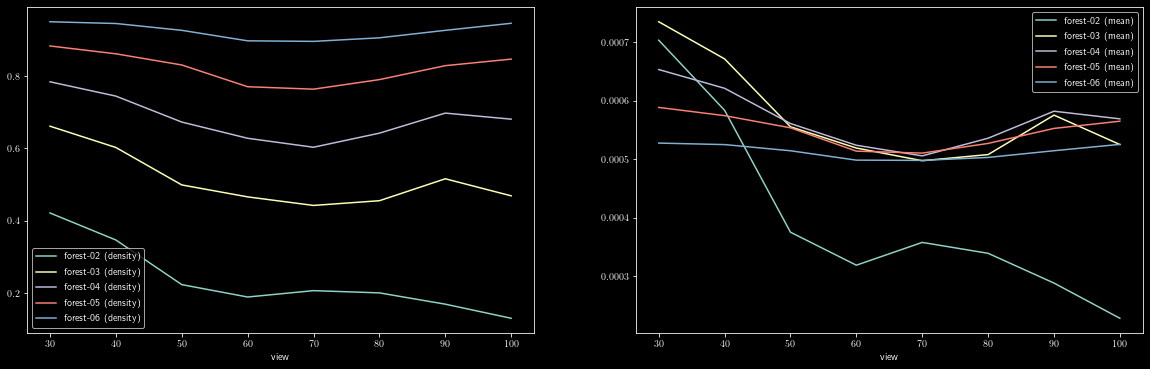

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

column_mask = ['density', 'mean', 'view', 'preset', 'size']
row_mask = (df['view'] >= 10) & (df['view'] <= 100) & (df['size'] >= 300)

for i, (preset, group) in enumerate(df[column_mask][row_mask].groupby('preset')):
    group.plot(x='view', y='density', label=preset + ' (density)', ax=axs[0])
    group.plot(x='view', y='mean', label=preset + ' (mean)', ax=axs[1])
    #group.plot(kind='barh', x='view', y='captured', label=preset + ' (captured)', color=f'C{i}', ax=axs[1])

In [7]:
def aggregate_alphas(alphas):
    #alphas_idx = np.nonzero(alphas[:, :, 1])
    alphas_idx = np.nonzero(alphas[:, :, 0])

    alphas_idx_x, alphas_idx_y, alphas_idx_a = alphas_idx
    
    # alpha values
    scanned_alphas = alphas[alphas_idx_x, alphas_idx_y, 0, alphas_idx_a]
    visible_alphas = alphas[alphas_idx_x, alphas_idx_y, 1, alphas_idx_a]
    
    # alphas data
    data_alphas = np.array([alphas_idx_a, scanned_alphas, visible_alphas]).T
    
    # alphas dataframe
    df_alphas = pd.DataFrame(data_alphas, columns=['alpha', 'scanned', 'visible'])
    df_alphas = df_alphas.apply(pd.to_numeric, downcast='integer')
    
    # aggregate alphas
    df_alphas_agg = df_alphas.groupby('alpha').sum()
    df_alphas_agg['result'] = df_alphas_agg['visible'] / df_alphas_agg['scanned']
    
    return df_alphas_agg.reset_index()

def plot_alphas(df, mask, groups, title):
    df_group = df[['view', 'preset', 'size', 'data_alpha']][mask].groupby(groups[0])
    
    # init plot
    n_cols, n_rows = 2, np.ceil(len(df_group) / 2).astype(np.int16)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 7))
    
    # aggregate data
    for i, (name_0, group_0) in enumerate(df_group):
        ax = axs[i // 2, i % 2]
        for j, alphas in enumerate(group_0['data_alpha']):
            
            # alpha dataframe
            df_alpha = aggregate_alphas(alphas)
            df_alpha['view'] = group_0['view'].iloc[j]
            df_alpha['preset'] = group_0['preset'].iloc[j]
            df_alpha['size'] = group_0['size'].iloc[j]
            
            # filter corner alphas
            df_alpha = df_alpha[df_alpha['alpha'] <= df_alpha['view'] / 2]
            
            # plot alphas
            for name_1, group_1 in df_alpha.groupby(groups[1]):
                group_1.plot(x='alpha', y='result', label=f'{name_1} (visible/scanned)', ax=ax)
        
        # plot title and legend
        ax.set_title(title % name_0)
        ax.legend(title=groups[1])

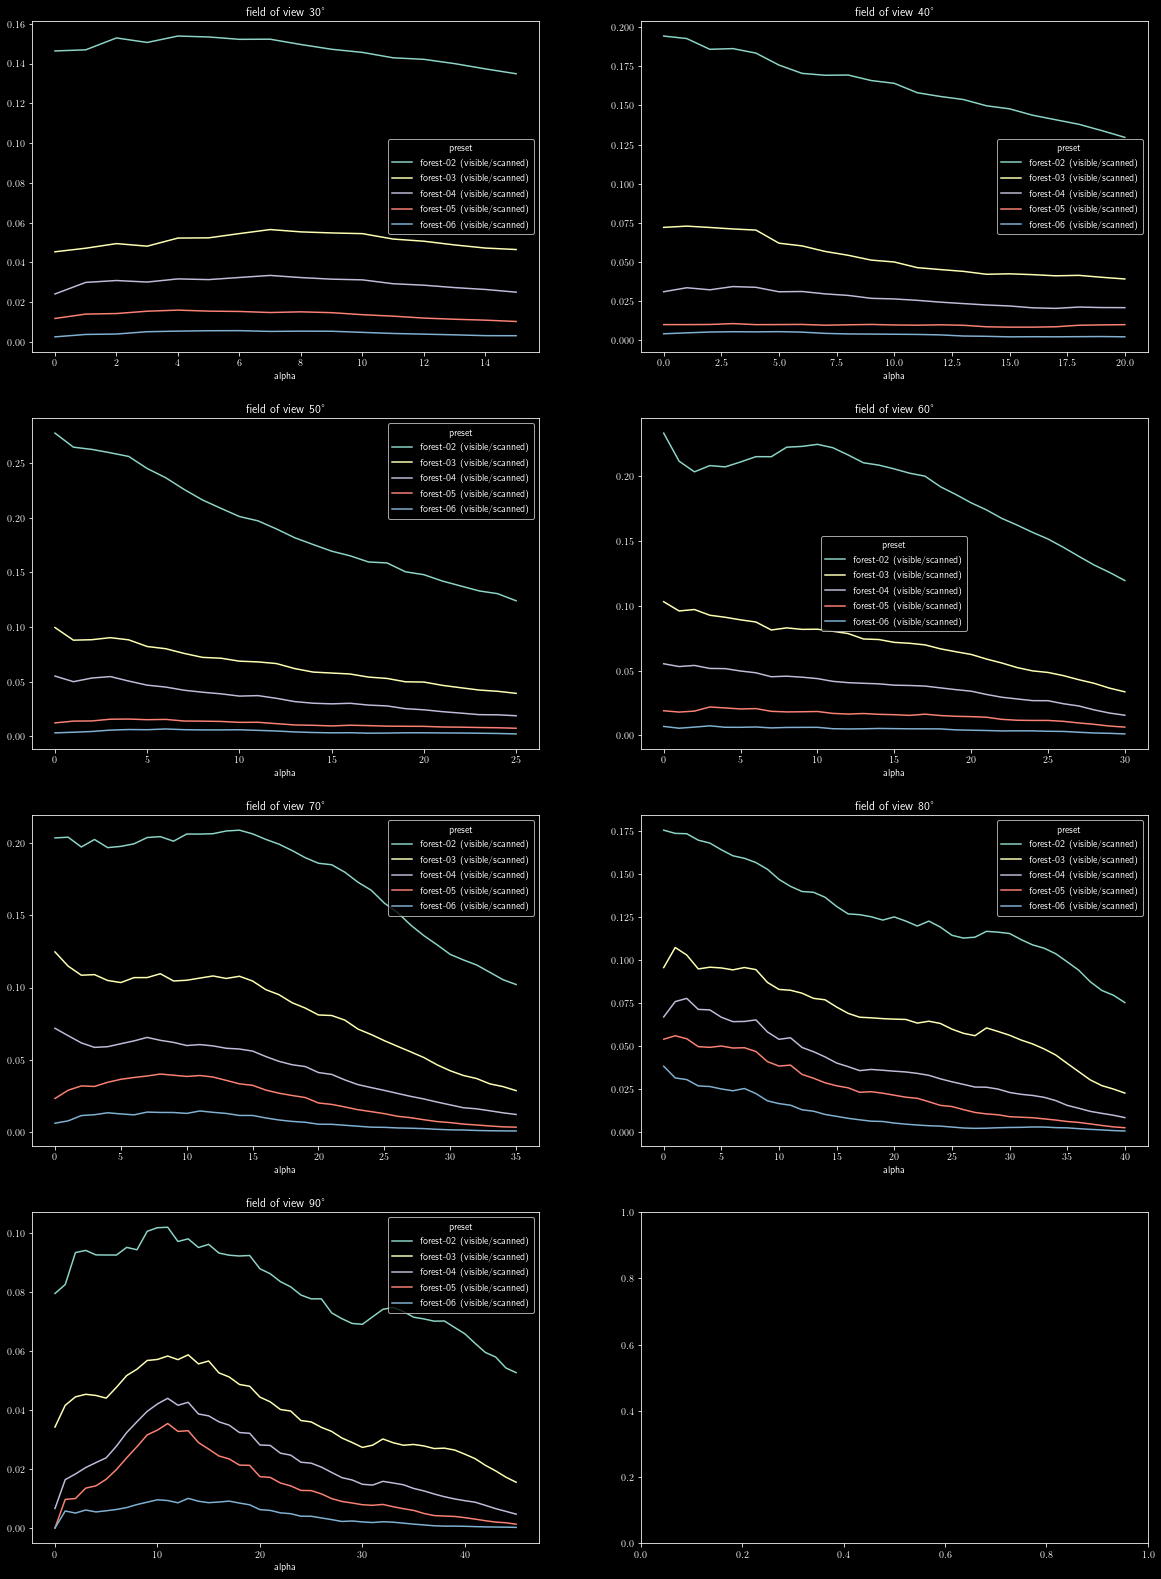

In [8]:
mask = (df['view'] >= 30) & (df['view'] <= 90) & (df['size'] >= 300)

plot_alphas(df, mask, ['view', 'preset'], 'field of view %s°')

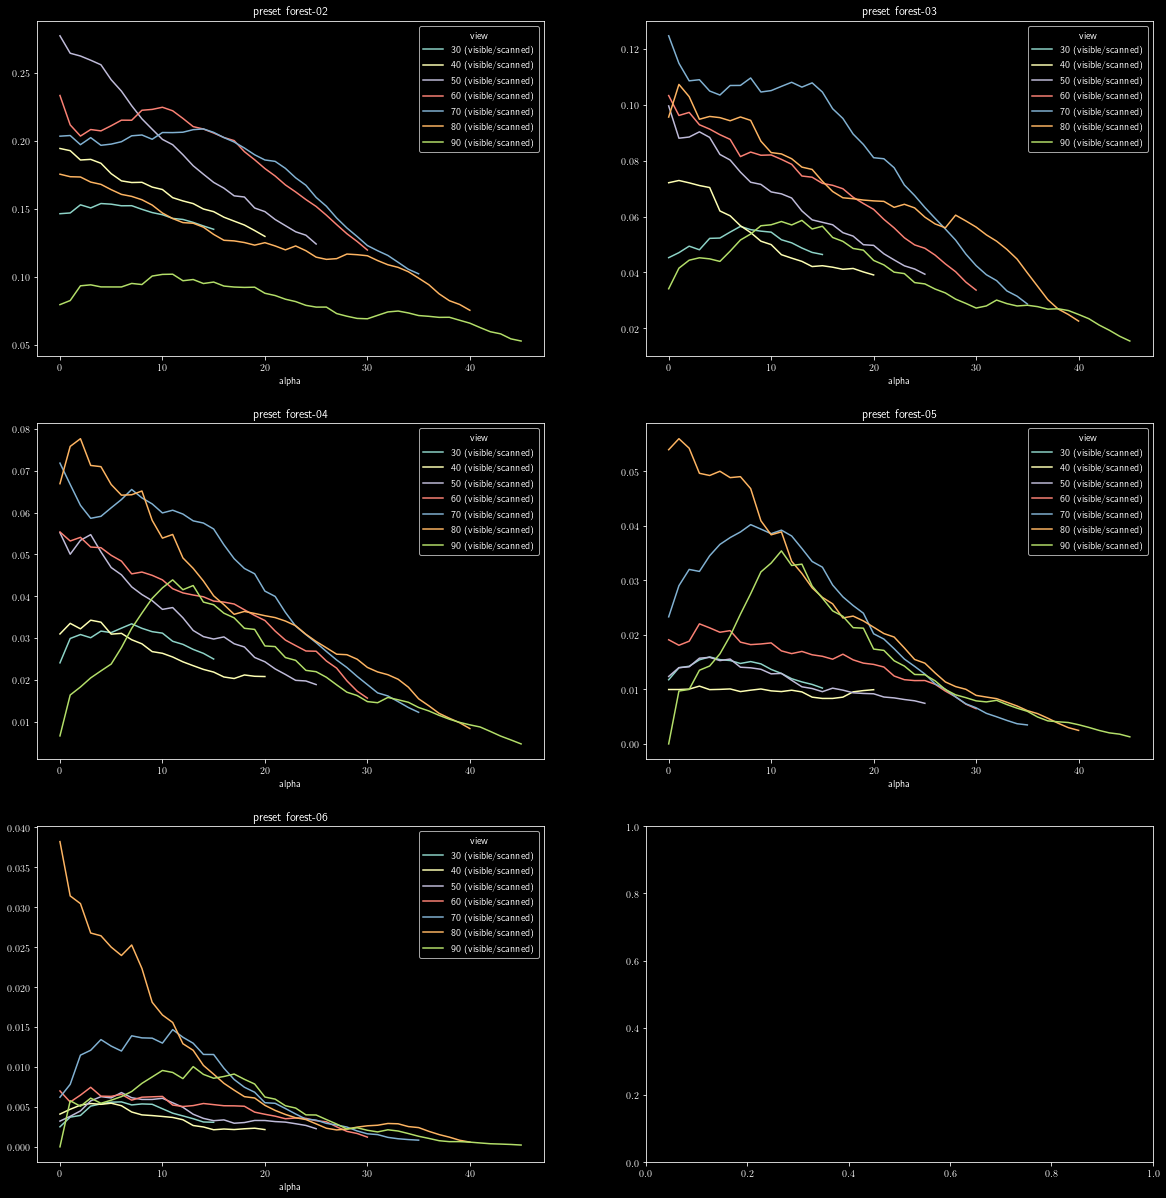

In [9]:
mask = (df['view'] >= 30) & (df['view'] <= 90) & (df['size'] >= 300)

plot_alphas(df, mask, ['preset', 'view'], 'preset %s')

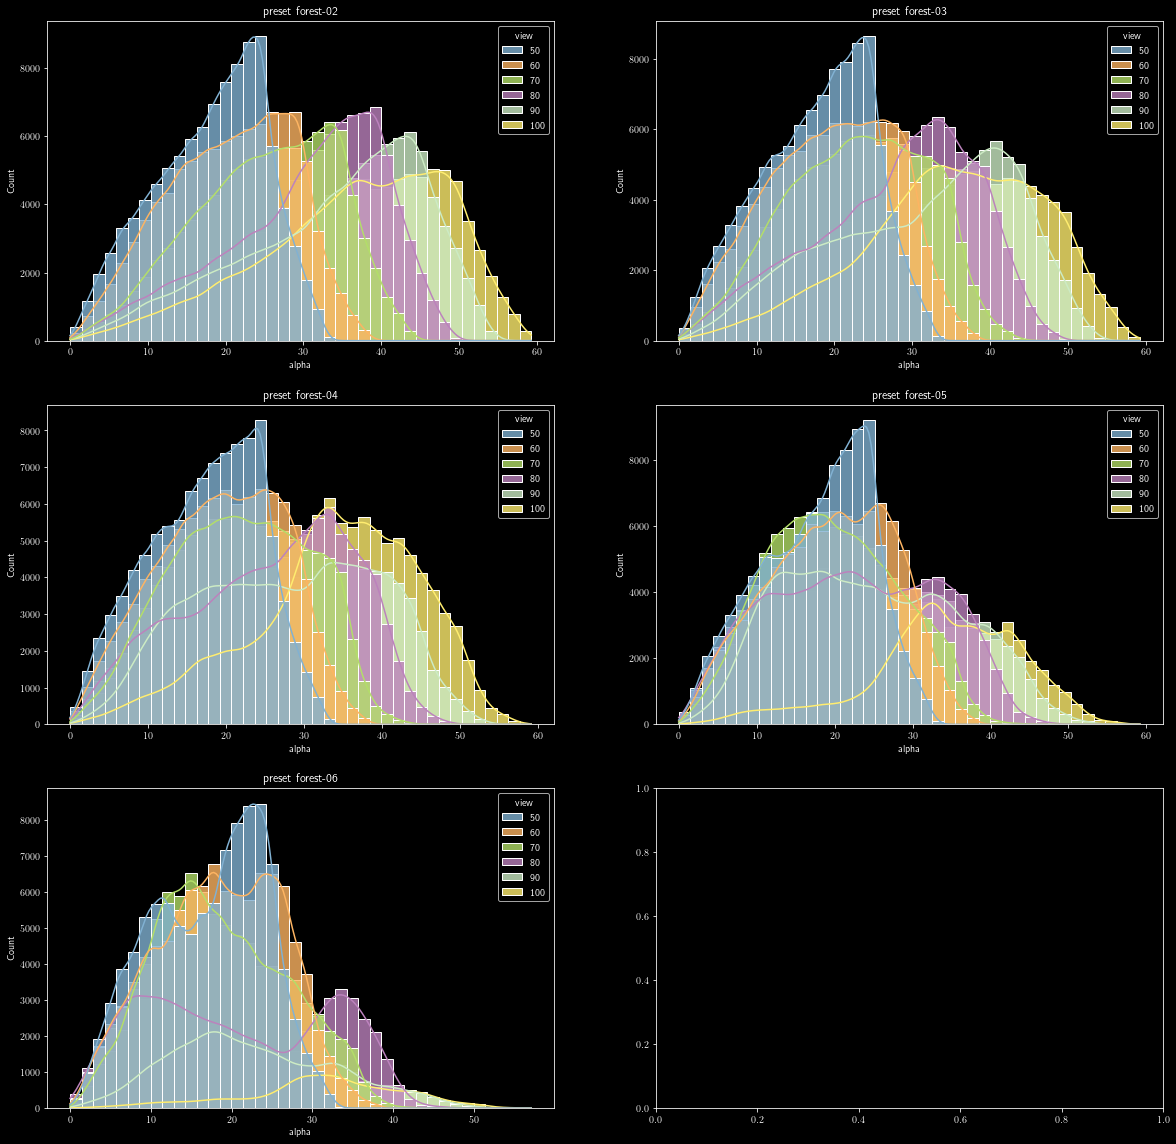

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

column_mask = ['view', 'preset', 'size', 'data_alpha']
row_mask = (df['view'] >= 50) & (df['view'] <= 900) & (df['size'] >= 300)

for i, (preset, group) in enumerate(df[column_mask][row_mask].groupby('preset')):
    df_alphas = pd.DataFrame()
    
    for j, alphas in enumerate(group['data_alpha']):
        
        # alpha dataframe
        df_alpha = pd.DataFrame(alphas.T, columns=['visible_x', 'visible_y', 'camera_x', 'camera_y', 'alpha'])
        df_alpha = df_alpha.sample(n=np.minimum(df_alpha.shape[0], 10**5), random_state=42)
        
        # alpha parameters
        df_alpha['view'] = group['view'].iloc[j]
        df_alpha['preset'] = group['preset'].iloc[j]
        df_alpha['size'] = group['size'].iloc[j]
        
        # append alphas
        df_alphas = pd.concat([df_alphas, df_alpha], ignore_index=True)
    
    # plot histogramms
    ax = axs[i // 2, i % 2]
    ax.set_title(f'preset {preset}')
    
    unique = df['view'].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    sns.histplot(df_alphas, x='alpha', hue='view', palette=palette, bins=40, alpha=0.8, kde=True, ax=ax)

# Density

 ### $\tilde{D}$ ... integrated density

$$
\begin{aligned}
    \tilde{D} &= 1 - \left(1 - D\right)^{\frac{l}{o \cdot \cos\left(\alpha\right)}} \qquad \qquad 
    \begin{aligned}
        &\text{D} &&\text{... uniform density per slice} \\
        &\text{l} &&\text{... occluder volume height} \\
        &\text{o} &&\text{... occluder cubic size} \\
        &\alpha &&\text{... obligue angle}, \frac{FOV}{2}
    \end{aligned}
\end{aligned}
$$

In [6]:
def D_tilde(D, lo, a):
    return 1 - (1 - D)**(lo * (1 / np.cos(np.deg2rad(a))))

In [7]:
@pyw.interact
def plot(lo=pyw.IntRangeSlider(value=(0, 300), min=0, max=300, continuous_update=True),
         a=pyw.IntSlider(value=0, min=0, max=90, continuous_update=True)):
    
    D = np.array([0.10, 0.25, 0.50, 1.00, 2.50, 10.00]) / 100
    D_tilde_lo_vs_D = [np.hstack([[x], D_tilde(D, x, a)]) for x in range(*lo)]
    
    # dataframe
    columns = ['lo'] + [f'D = {x*100:.2f} \%' for x in D]
    df = pd.DataFrame(D_tilde_lo_vs_D, columns=columns).set_index('lo')
    
    # plot
    ax = df.plot(figsize=(16, 8))
    ax.set(ylabel=r'density $\tilde{D}$')

interactive(children=(IntRangeSlider(value=(0, 300), description='lo', max=300), IntSlider(value=0, descriptio…

 ### $\tilde{D}_{\alpha}$ ... integrated obligue angle density

$$
\begin{aligned}
    \tilde{D}_{\alpha} &= 1 - \left(1 - \tilde{D}\right)^{\frac{1}{\cos\left(\alpha\right)}} \qquad \qquad 
    \begin{aligned}
        &\tilde{D} &&\text{... integrated density} \\
        &\alpha &&\text{... obligue angle}, \frac{FOV}{2}
    \end{aligned}
\end{aligned}
$$

In [8]:
def D_tilde_alpha(D, lo, a):
    return 1 - (1 - D_tilde(D, lo, 0))**(1 / np.cos(np.deg2rad(a)))

In [9]:
@pyw.interact
def plot(fov=pyw.IntRangeSlider(value=(0, 180), min=0, max=180, continuous_update=True),
         lo=pyw.IntSlider(value=140, min=0, max=300, continuous_update=True)):
    
    D = np.array([0.10, 0.25, 0.50, 1.00, 2.50, 10.00]) / 100
    D_tilde_fov_vs_D = [np.hstack([[x / 2], D_tilde_alpha(D, lo, x / 2)]) for x in range(*fov)]
    
    # dataframe
    columns = [r'$\alpha$ (deg)'] + [f'D = {x*100:.2f} \%' for x in D]
    df = pd.DataFrame(D_tilde_fov_vs_D, columns=columns).set_index(r'$\alpha$ (deg)')
    
    # plot
    ax = df.plot(figsize=(16, 8))
    ax.set(ylabel=r'density $\tilde{D}_{\alpha}$')

interactive(children=(IntRangeSlider(value=(0, 180), description='fov', max=180), IntSlider(value=140, descrip…

# Visibility

### $\hat{d}$ ... optimal disparity

$$
\begin{aligned}
    \hat{d} &= \frac{d}{o} \geq 1 \qquad \qquad 
    \begin{aligned}
        &\text{d} &&\text{... disparity shift between SAI samples} \\
        &\text{o} &&\text{... occluder cubic size} \\
    \end{aligned}
\end{aligned}
$$

### $V$ ... visibility assuming optimal disparity

$$
\begin{aligned}
    V &= 1 - \tilde{D}^{2} - \frac{\tilde{D}(1 - \tilde{D})}{N} \qquad \qquad 
    \begin{aligned}
        &\tilde{D} &&\text{... integrated density} \\
        &N &&\text{... number of SAI samples}
    \end{aligned}
\end{aligned}
$$

In [10]:
def V(D, N):
    return 1 - D**2 - D * (1 - D) / N

In [11]:
@pyw.interact
def plot():
    
    D = np.linspace(0, 1, 1000)
    N = np.array([1, 2, 4, 9, 25, 100])
    V_D_vs_N = [np.hstack([[x], V(x, N)]) for x in D]
    
    # dataframe
    columns = [r'density $\tilde{D}$'] + [f'N = {x}' for x in N]
    df = pd.DataFrame(V_D_vs_N, columns=columns).set_index(r'density $\tilde{D}$')
    
    # plot
    ax = df.plot(figsize=(16, 8))
    ax.set(ylabel=r'visibility $V$')

interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Optimization

#### Coverage - Distance - Sampling
$$
\begin{aligned}
    I_c = 2 \cdot h \cdot \tan\left(\frac{\text{FOV}}{2}\right), \qquad \qquad I_d = v \cdot t_p , \qquad \qquad I_s = \frac{I_c}{s_d} = 30 \\
\end{aligned}
$$

#### Resolution - Overlap - Time
$$
\begin{aligned}
    I_r = \frac{I_c}{r}, \qquad \qquad I_o = \frac{I_c}{I_d}, \qquad \qquad I_t = \frac{I_c}{v} = \frac{s_d}{v} \cdot I_s
\end{aligned}
$$

## Constraints - Dynamic
$$
\begin{aligned}
    C_d &= \left\{ v, h, \text{FOV}, s_d \right\} \\
\end{aligned}
$$

## Constraints - Hardware
$$
\begin{aligned}
    C_h &= \left\{ t_p, r, f \right\} \\
\end{aligned}
$$

## Constraints - Quality
$$
\begin{aligned}
    C_q &= \left\{ I_r, I_o, I_t \right\} \\
    &= \left\{ \frac{I_c}{r}, \frac{I_c}{I_d}, \frac{I_c}{v} \right\} \\
    &= \left\{ \frac{I_c}{r}, \frac{I_c}{v \cdot t_p}, \frac{I_c}{v} \right\} \\
\end{aligned}
$$

In [12]:
@pyw.interact
def plot(fov=pyw.IntRangeSlider(value=(10, 160), min=10, max=160, continuous_update=True),
         h=pyw.IntSlider(value=35, min=1, max=100, continuous_update=True),
         v=pyw.IntSlider(value=4, min=1, max=20, continuous_update=True)):
    
    n = 10000
        
    FOV = np.linspace(*fov, n)
    H = np.repeat(h, n)
    V = np.repeat(v, n)
    
    s_d = 1
    
    # constraints - hardware
    t_p = 0.5
    r = 512
    f = 10
    
    # coverage - distance - sampling
    I_c = 2 * H * np.tan(np.deg2rad(FOV / 2))
    I_d = V * t_p
    I_s = I_c / s_d # = 30
    
    # resolution - overlap - time
    I_r = I_c / r
    I_o = I_c / I_d
    I_t = I_c / V
    
    # constraints
    C_h = (t_p, r, f)
    C_d = (V, H, FOV, s_d)
    C_b = (I_c, I_d, I_s)
    C_q = (I_r, I_o, I_t)
    
    # dataframe
    columns = [r'FOV'] + [r'Coverage ($I_c$)', r'Resolution ($I_r$)', r'Overlap ($I_o$)', r'Time ($I_t$)']
    df = pd.DataFrame(np.vstack([[FOV], [I_c], C_q]).T, columns=columns).set_index(r'FOV')
    
    # plot
    ax = df.plot(figsize=(16, 8))
    ax.set(ylabel=r'quality $C_q$')

interactive(children=(IntRangeSlider(value=(10, 160), description='fov', max=160, min=10), IntSlider(value=35,…